# Problem 4

Use this notebook to write your code for problem 4.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 3D - Convolutional network

As in problem 3, we have conveniently provided for your use code that loads and preprocesses the MNIST data.

In [ ]:
# load MNIST data into PyTorch format
import torch
import torchvision
import torchvision.transforms as transforms

torch.manual_seed(0)

# set batch size
batch_size = 32

# load training data downloaded into data/ folder
mnist_training_data = torchvision.datasets.MNIST('data/', train=True, download=True,
                                                transform=transforms.ToTensor())
# transforms.ToTensor() converts batch of images to 4-D tensor and normalizes 0-255 to 0-1.0
training_data_loader = torch.utils.data.DataLoader(mnist_training_data,
                                                  batch_size=batch_size,
                                                  shuffle=True)

# load test data
mnist_test_data = torchvision.datasets.MNIST('data/', train=False, download=True,
                                                transform=transforms.ToTensor())
test_data_loader = torch.utils.data.DataLoader(mnist_test_data,
                                                  batch_size=batch_size,
                                                  shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
# look at the number of batches per epoch for training and validation
print(f'{len(training_data_loader)} training batches')
print(f'{len(training_data_loader) * batch_size} training samples')
print(f'{len(test_data_loader)} validation batches')

1875 training batches
60000 training samples
313 validation batches


In [ ]:
# sample model
import torch.nn as nn

model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=(3,3)),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Dropout(p=0.2),
    
    nn.Conv2d(32, 32, kernel_size=(3,3)), nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Dropout(p=0.2),
    
    nn.Flatten(),
    nn.Linear(25*32, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
    # PyTorch implementation of cross-entropy loss includes softmax layer
)

In [ ]:
# why don't we take a look at the shape of the weights for each layer
for p in model.parameters():
    print(p.data.shape)

torch.Size([32, 1, 3, 3])
torch.Size([32])
torch.Size([32, 32, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([64, 800])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])


In [ ]:
# our model has some # of parameters:
count = 0
trainable_count = 0
for p in model.parameters():
    n_params = np.prod(list(p.data.shape)).item()
    count += n_params
    if p.requires_grad:
        trainable_count += n_params
print(f'total params: {count}\ntrainable params: {trainable_count}')

total params: 61546
trainable params: 61546


In [ ]:
# For a multi-class classification problem
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters())

# Visualization

We are providing you with a function to help you visualize what your model is learning.

Your model takes takes in an image as input and outputs a vector in 10-dimensional space. If your model is a good digit classifier, then you would expect that output vectors corresponding to the same digit should be close together in this 10-dimensional space. If it achieves that, then we say it learned a useful representation of the digits - your model is capable of encoding incredibly high-dimensional data (raw-pixels of an image) into a more compact 10-dimensional space.

While we cannot directly visualize a high-dimensional space, we can project these vectors into 2 dimensions to get a sense of what is going on. We do this using an algorithm called tSNE.

In [ ]:
from sklearn.manifold import TSNE

def visualize_predictions(model):
    #  TSNE projects high-dimensional vectors to 2D space
    tsne = TSNE(n_components=2, learning_rate="auto", init="random")

    sample_size = 1000
    data_sampler = torch.utils.data.DataLoader(mnist_training_data, batch_size=sample_size, shuffle=True)
    sample = next(iter(data_sampler))
    images, labels = sample
    feature_vectors = model(images)
    features_2D = tsne.fit_transform(feature_vectors.detach().numpy())

    for digit in range(0, 10):
        points_x, points_y = [], []
        for i in range(len(features_2D)):
            if labels[i].item() == digit:
                points_x.append(features_2D[i, 0])
                points_y.append(features_2D[i, 1])
        plt.scatter(points_x, points_y, label=f"{digit}")

    plt.legend()
    plt.show()

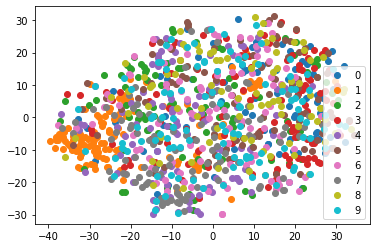

In [ ]:
# an untrained model classifies digits at random!
visualize_predictions(model)

### Train loop

In [ ]:
# Train the model for 10 epochs, iterating on the data in batches
n_epochs = 10

# store metrics
training_accuracy_history = np.zeros([n_epochs, 1])
training_loss_history = np.zeros([n_epochs, 1])
validation_accuracy_history = np.zeros([n_epochs, 1])
validation_loss_history = np.zeros([n_epochs, 1])

for epoch in range(n_epochs):
    print(f'Epoch {epoch+1}/10:', end='')
    train_total = 0
    train_correct = 0
    # train
    model.train()
    for i, data in enumerate(training_data_loader):
        images, labels = data
        optimizer.zero_grad()
        # forward pass
        output = model(images)
        # calculate categorical cross entropy loss
        loss = criterion(output, labels)
        # backward pass
        loss.backward()
        optimizer.step()
        
        # track training accuracy
        _, predicted = torch.max(output.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        # track training loss
        training_loss_history[epoch] += loss.item()
        # progress update after 180 batches (~1/10 epoch for batch size 32)
        if i % 180 == 0: print('.',end='')
    training_loss_history[epoch] /= len(training_data_loader)
    training_accuracy_history[epoch] = train_correct / train_total
    print(f'\n\tloss: {training_loss_history[epoch,0]:0.4f}, acc: {training_accuracy_history[epoch,0]:0.4f}',end='')
        
    # validate
    test_total = 0
    test_correct = 0
    with torch.no_grad():
        model.eval()
        for i, data in enumerate(test_data_loader):
            images, labels = data
            # forward pass
            output = model(images)
            # find accuracy
            _, predicted = torch.max(output.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            # find loss
            loss = criterion(output, labels)
            validation_loss_history[epoch] += loss.item()
        validation_loss_history[epoch] /= len(test_data_loader)
        validation_accuracy_history[epoch] = test_correct / test_total
    print(f', val loss: {validation_loss_history[epoch,0]:0.4f}, val acc: {validation_accuracy_history[epoch,0]:0.4f}')

Epoch 1/10:...........
	loss: 0.4016, acc: 0.9193, val loss: 0.0928, val acc: 0.9707
Epoch 2/10:...........
	loss: 0.1021, acc: 0.9705, val loss: 0.1269, val acc: 0.9619
Epoch 3/10:...........
	loss: 0.0868, acc: 0.9746, val loss: 0.0790, val acc: 0.9789
Epoch 4/10:...........
	loss: 0.0779, acc: 0.9768, val loss: 0.0518, val acc: 0.9843
Epoch 5/10:...........
	loss: 0.0760, acc: 0.9786, val loss: 0.0726, val acc: 0.9794
Epoch 6/10:...........
	loss: 0.0722, acc: 0.9794, val loss: 0.0591, val acc: 0.9814
Epoch 7/10:...........
	loss: 0.0729, acc: 0.9796, val loss: 0.0488, val acc: 0.9858
Epoch 8/10:...........
	loss: 0.0681, acc: 0.9811, val loss: 0.0405, val acc: 0.9880
Epoch 9/10:...........
	loss: 0.0665, acc: 0.9820, val loss: 0.0443, val acc: 0.9885
Epoch 10/10:...........
	loss: 0.0664, acc: 0.9818, val loss: 0.0466, val acc: 0.9871


Above, we output the training loss/accuracy as well as the validation loss and accuracy. Not bad! Let's see if you can do better.

### Trained model visualization

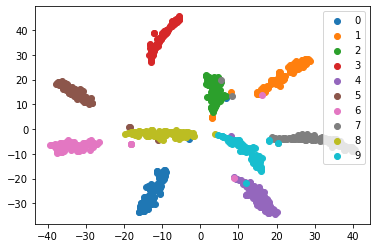

In [ ]:
# A trained model should be able to group input images by digit!
visualize_predictions(model)